In [1]:
import websocket, json, pprint, talib, numpy
from binance.client import Client
from binance.enums import *
import config
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import joblib



In [101]:
interval_15 = 675000000
interval_1 = 45000000

currMilli = round(time.time() * 1000)
endTime = currMilli - int(2.628e+9)*5


i = 0
candles = []

client = Client(config.KEY, config.SECRET, tld='us')

while(len(candles) < 25000):
    currCandles = client.get_klines(symbol='ETHUSDT', 
                                interval=Client.KLINE_INTERVAL_1MINUTE, 
                                startTime = (endTime - interval_15), 
                                endTime = (endTime),
                                limit = 500)

    
    closes = []
    volumes = []
    
    #print(currCandles)
    
    #print(len(currCandles))
    
    for i in range(len(currCandles)):
        candle = currCandles[i]
        close = float(candle[4])
        volume = float(candle[5])

        if(len(closes) == 15):
            obv = talib.OBV(np.array(closes), np.array(volumes))
            rsi = talib.RSI(np.array(closes), 14)
            candle.append(rsi[-1])
            candle.append(obv[-1])
            candles.append(candle)
            closes = closes[:-1]
            volumes = volumes[:-1]

        closes.insert(0, close)
        volumes.insert(0, volume)
        
    print("YES", len(candles))
    endTime += interval_1
    
print('\n\n\nFINAL\n\n', len(candles))

YES 485
YES 970
YES 1455
YES 1940
YES 2425
YES 2910
YES 3395
YES 3880
YES 4365
YES 4850
YES 5335
YES 5820
YES 6305
YES 6790
YES 7275
YES 7760
YES 8245
YES 8730
YES 9215
YES 9700
YES 10185
YES 10670
YES 11155
YES 11640
YES 12125
YES 12610
YES 13095
YES 13580
YES 14065
YES 14550
YES 15035
YES 15520
YES 16005
YES 16490
YES 16975
YES 17460
YES 17945
YES 18430
YES 18915
YES 19400
YES 19885
YES 20370
YES 20855
YES 21340
YES 21825
YES 22310
YES 22795
YES 23280
YES 23765
YES 24250
YES 24735
YES 25220



FINAL

 25220


In [102]:
opens = []
closes = []
highs = []
lows = []
volumes = []
qavs = []
numTrades = []
tbbavs = []
tbqavs = []
rsis = []
obvs = []
labels = []



for i in range(len(candles) - 1):
    c = candles[i]
    
    opens.append(c[1])
    highs.append(c[2])
    lows.append(c[3])
    closes.append(c[4])
    volumes.append(c[5])
    qavs.append(c[7])
    numTrades.append(c[8])
    tbbavs.append(c[9])
    tbqavs.append(c[10])
    rsis.append(c[12])
    obvs.append(c[13])
    labels.append(1 if (candles[i+1][4] > c[4]) else 0)
    
df = pd.DataFrame(data={"opens": opens, "highs": highs, "lows": lows, "closes": closes, "volumes": volumes, "qavs": qavs, "numTrades": numTrades, "tbbavs": tbbavs, "tbqavs": tbqavs, "rsis": rsis,"obvs": obvs})
print(df.tail())

scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns = df.columns)
scaled_df['labels'] = labels
scaled_df.head()

joblib.dump(scaler, 'standard_scaler_15m.save') 

scaled_df.to_csv("./data_15m.csv", sep=',',index=False)

               opens          highs           lows         closes     volumes  \
25214  3744.41000000  3744.41000000  3744.41000000  3744.41000000  2.00000000   
25215  3744.41000000  3744.41000000  3744.41000000  3744.41000000  0.00000000   
25216  3744.41000000  3744.41000000  3744.41000000  3744.41000000  0.00000000   
25217  3743.31000000  3743.31000000  3743.31000000  3743.31000000  0.05298000   
25218  3741.66000000  3741.66000000  3741.66000000  3741.66000000  0.05341000   

                qavs  numTrades      tbbavs        tbqavs       rsis     obvs  
25214  7488.82000000          1  0.00000000    0.00000000  35.307018  1.90247  
25215     0.00000000          0  0.00000000    0.00000000  43.809524  3.90247  
25216     0.00000000          0  0.00000000    0.00000000  43.809524  1.90247  
25217   198.32056380          1  0.05298000  198.32056380  43.809524  1.90247  
25218   199.84206060          1  0.05341000  199.84206060  49.137931  1.95545  


In [76]:
data = pd.read_csv('data_15m.csv')
data.head(100)

,opens,highs,lows,closes,volumes,qavs,numTrades,tbbavs,tbqavs,rsis,obvs,labels
0,0.354561,0.358927,0.347900,0.342302,-0.180493,-0.179451,-0.104139,-0.289990,-0.290618,0.321905,3.447637,1
1,0.352672,0.356094,0.358409,0.360033,-0.017283,-0.012300,0.119985,-0.190638,-0.189510,0.540247,3.519875,0
2,0.323270,0.328265,0.328994,0.333965,-0.220953,-0.220922,-0.216202,-0.233489,-0.233177,0.024305,2.163982,0
3,0.330885,0.327987,0.336167,0.333687,0.851498,0.875646,0.232048,0.551825,0.565225,0.092616,2.063327,0
4,0.351838,0.366093,0.328383,0.322793,0.096158,0.103750,0.119985,-0.160458,-0.158993,-0.063735,2.041715,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.177654,0.178452,0.183311,0.182783,-0.120208,-0.119402,-0.104139,-0.145254,-0.144481,1.154941,1.957190,0
96,0.191938,0.186451,0.138383,0.163829,0.087246,0.090820,0.232048,0.454553,0.460386,1.111972,1.870060,0
97,0.147586,0.189895,0.153229,0.148322,0.585605,0.597135,0.736328,0.865014,0.875492,1.027046,1.753995,1
98,0.156812,0.180174,0.146834,0.156937,0.428960,0.437378,0.904422,0.128217,0.131106,1.029360,1.876086,1


[
[
1499040000000, # Open time
"0.01634790", # Open
"0.80000000", # High
"0.01575800", # Low
"0.01577100", # Close
"148976.11427815", # Volume
1499644799999, # Close time
"2434.19055334", # Quote asset volume
308, # Number of trades
"1756.87402397", # Taker buy base asset volume
"28.46694368", # Taker buy quote asset volume
"17928899.62484339" # Can be ignored
]
]

## 1 MINUTE

In [2]:
interval_15 = 675000000
interval_1 = 45000000

currMilli = round(time.time() * 1000)
endTime = currMilli - int(3.156e+10)


i = 0
candles = []

client = Client(config.KEY, config.SECRET, tld='us')

while(len(candles) < 43000):
    currCandles = client.get_klines(symbol='ETHUSDT', 
                                interval=Client.KLINE_INTERVAL_1MINUTE, 
                                startTime = (endTime - interval_1), 
                                endTime = (endTime),
                                limit = 750)

    
    closes = []
    volumes = []
    
    #print(currCandles)
    
    #print(len(currCandles))
    
    for i in range(len(currCandles)):
        candle = currCandles[i]
        close = float(candle[4])
        volume = float(candle[5])

        if(len(closes) == 15):
            obv = talib.OBV(np.array(closes), np.array(volumes))
            rsi = talib.RSI(np.array(closes), 14)
            candle.append(rsi[-1])
            candle.append(obv[-1])
            candles.append(candle)
            closes = closes[:-1]
            volumes = volumes[:-1]

        closes.insert(0, close)
        volumes.insert(0, volume)
        
    print("YES", len(candles))
    endTime += interval_1
print('\n\n\nFINAL\n\n', len(candles))

opens = []
closes = []
highs = []
lows = []
volumes = []
qavs = []
numTrades = []
tbbavs = []
tbqavs = []
rsis = []
obvs = []
labels = []



for i in range(len(candles) - 1):
    c = candles[i]
    
    opens.append(c[1])
    highs.append(c[2])
    lows.append(c[3])
    closes.append(c[4])
    volumes.append(c[5])
    qavs.append(c[7])
    numTrades.append(c[8])
    tbbavs.append(c[9])
    tbqavs.append(c[10])
    rsis.append(c[12])
    obvs.append(c[13])
    labels.append(1 if (candles[i+1][4] > c[4]) else 0)
    
df = pd.DataFrame(data={"opens": opens, "highs": highs, "lows": lows, "closes": closes, "volumes": volumes, "qavs": qavs, "numTrades": numTrades, "tbbavs": tbbavs, "tbqavs": tbqavs, "rsis": rsis,"obvs": obvs})
print(df.tail())

scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns = df.columns)
scaled_df['labels'] = labels
scaled_df.head()

joblib.dump(scaler, 'standard_scaler_1m.save') 

scaled_df.to_csv("./data_1m.csv", sep=',',index=False)

YES 735
YES 1470
YES 2205
YES 2940
YES 3675
YES 4410
YES 5145
YES 5880
YES 6615
YES 7350
YES 8085
YES 8820
YES 9555
YES 10290
YES 11025
YES 11760
YES 12495
YES 13230
YES 13965
YES 14700
YES 15435
YES 16170
YES 16905
YES 17640
YES 18375
YES 19110
YES 19845
YES 20580
YES 21315
YES 22050
YES 22785
YES 23520
YES 24255
YES 24990
YES 25725
YES 26460
YES 27195
YES 27930
YES 28665
YES 29400
YES 30135
YES 30870
YES 31605
YES 32340
YES 33075
YES 33810
YES 34545
YES 35280
YES 36015
YES 36750
YES 37485
YES 38220
YES 38955
YES 39690
YES 40425
YES 41160
YES 41895
YES 42630
YES 43365



FINAL

 43365
               opens          highs           lows         closes     volumes  \
43359  2418.13000000  2418.13000000  2411.66000000  2414.74000000  3.92679000   
43360  2413.99000000  2415.78000000  2413.94000000  2415.78000000  2.50426000   
43361  2415.89000000  2417.02000000  2415.38000000  2415.38000000  3.17633000   
43362  2416.39000000  2418.93000000  2416.39000000  2418.92000000  0.47061000   
43

In [35]:
data = pd.read_csv('data_1m.csv')
data.head(100)

,opens,highs,lows,closes,volumes,qavs,numTrades,tbbavs,tbqavs,rsis,obvs,labels
0,1.054611,1.055470,1.054335,1.056522,-0.147398,-0.081989,-0.248064,0.143373,0.262419,-0.230515,-0.268529,1
1,1.051269,1.056165,1.053611,1.058508,-0.426151,-0.432511,-0.410431,-0.359055,-0.354545,-0.285871,-0.227876,0
2,1.052436,1.054206,1.051316,1.053653,-0.318868,-0.297685,0.022547,-0.282430,-0.260461,-0.600140,-0.371549,1
3,1.055683,1.071685,1.053014,1.073987,0.027576,0.138916,-0.139819,0.483692,0.681873,-0.564150,-0.356908,0
4,1.071259,1.071685,1.067292,1.070992,-0.318355,-0.296648,-0.275125,-0.157530,-0.106569,-1.182156,-0.304651,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.067349,1.066059,1.062858,1.068376,-0.037523,0.056572,0.049609,0.117107,0.230741,0.092666,0.305922,1
96,1.067191,1.081768,1.069494,1.079946,-0.293677,-0.265552,0.266098,-0.289701,-0.269118,0.645106,0.285124,1
97,1.079236,1.094632,1.081508,1.095204,-0.379046,-0.372886,-0.004514,-0.357761,-0.352745,-0.205364,0.062822,1
98,1.092383,1.094379,1.089182,1.096402,-0.415842,-0.419304,-0.302186,-0.350956,-0.344331,-0.690558,0.008683,1


            time     opens     highs      lows    closes    volumes  \
0   1.652595e+12 -2.260501 -2.266743 -2.267751 -2.273477  58.271574   
1   1.652595e+12 -2.273505 -2.270148 -2.266579 -2.267423  74.353524   
2   1.652595e+12 -2.267451 -2.265196 -2.261616 -2.258373  25.864665   
3   1.652595e+12 -2.258431 -2.264237 -2.254526 -2.257415  30.678896   
4   1.652596e+12 -2.257474 -2.260213 -2.254187 -2.253585  23.387478   
..           ...       ...       ...       ...       ...        ...   
79  1.652600e+12 -2.228440 -2.234651 -2.225611 -2.227980  25.675547   
80  1.652600e+12 -2.228069 -2.231308 -2.221203 -2.227238  31.972966   
81  1.652600e+12 -2.227328 -2.231432 -2.225334 -2.231871  13.995662   
82  1.652600e+12 -2.231930 -2.228894 -2.225056 -2.222173  16.867751   
83  1.652600e+12 -2.222200 -2.228894 -2.222775 -2.227269  17.120149   

         qavs  numTrades     tbbavs     tbqavs      rsis      obvs  money  \
0   45.472244  35.750942  28.684727  22.085931 -2.448922 -0.079892   0

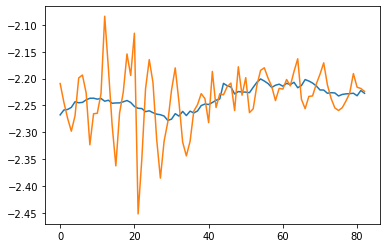

In [108]:
import joblib
scaler = joblib.load('standard_scaler_1m.save')
data1 = pd.read_csv('datahistroy_1m_2.csv')
pred = data1.loc[:, "predictionBefore"].to_numpy()[1:]
true = data1.loc[:, "trueAfter"].to_numpy()[1:]
prev = data1.loc[:, "closes"].to_numpy()
true = [float(c.item()) for c in true]
print(data1)

plt.plot(true)
plt.plot(pred)
#plt.plot(prev)

            time     opens     highs      lows    closes     volumes  \
1   1.652595e+12 -2.273505 -2.270148 -2.266579 -2.267423   74.353524   
2   1.652595e+12 -2.267451 -2.265196 -2.261616 -2.258373   25.864665   
7   1.652596e+12 -2.244964 -2.249815 -2.238558 -2.244257    7.021031   
8   1.652596e+12 -2.244316 -2.246318 -2.237418 -2.239562    8.584146   
11  1.652596e+12 -2.236470 -2.241304 -2.233441 -2.238203   46.617903   
12  1.652596e+12 -2.238262 -2.242666 -2.238620 -2.236937   23.568932   
14  1.652596e+12 -2.242092 -2.246968 -2.238158 -2.240211   12.984592   
15  1.652596e+12 -2.240270 -2.246163 -2.239082 -2.245925   26.046066   
18  1.652596e+12 -2.245242 -2.249598 -2.240439 -2.243145   14.759621   
19  1.652596e+12 -2.243204 -2.244925 -2.236339 -2.240736   22.916630   
22  1.652597e+12 -2.251883 -2.258542 -2.252553 -2.255191   33.839585   
23  1.652597e+12 -2.255250 -2.258202 -2.249532 -2.255686   23.938412   
25  1.652597e+12 -2.261520 -2.263277 -2.254619 -2.259824   28.92

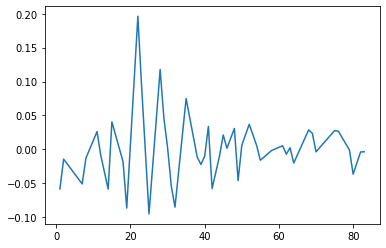

In [118]:
correct = data1[data1['correct'] == 1]
wrong = data1[data1['correct'] == 0]
plt.plot(correct['diff'])
print(correct)

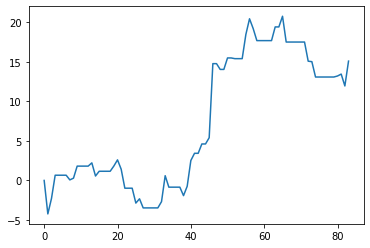

In [117]:
money = data1.loc[:, "money"].to_numpy()
plt.plot(money)

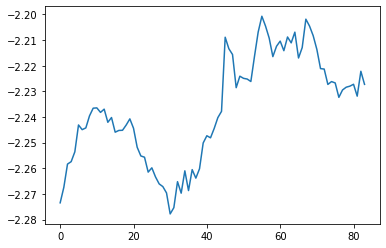

In [111]:
closes = data1.loc[:, "closes"].to_numpy()
plt.plot(closes)